# Deep Learning for Computer Vision:  Assignment 1


## Computer Science: COMS W 4995 007


### Due: October 1, 2019

#### Problem 1

You are asked to produce a minumum error rate classifier for a 3-class classification problem. Your feature space is 2-dimensional. Let's say the class conditional density functions (or likelihoods) are known and given by $\rho({\bf x}|y_i)$
where ${\bf x}$ is your feature and $y_i$ specifies the class. Let's also assume that the priors $P(y_i)$ are also given. (Both of these are specified below.) Show the decision regions for each of the three classes. Hint: you can show this by densely generating sample points ${\bf x}_j \in X$ in the feature space, classifying them, and then plotting and coloring them according to their predicted label.

Let the ccds and priors be given as:
    

$$\rho({\bf x}|y_1) \sim N({\bf \mu}_1, \Sigma_1)  \text{ and } P(y_1) = 0.5\,\, \text{ where } \,\, 
{\bf \mu}_1 = \left[\begin{array}{c} 1 \\ 1  \end{array} \right]
\,\, \text{ and } 
\Sigma_1 = \left[\begin{array}{cc} 1 & 0 \\ 0 & 0.5  \end{array} \right] $$


#### $$\rho({\bf x}|y_2) \sim N({\bf \mu}_2, \Sigma_2)  \text{ and } P(y_2) = 0.4\,\, \text{ where } \,\, 
{\bf \mu}_2 = \left[\begin{array}{c} 1 \\ 0  \end{array} \right]
\,\, \text{ and } 
\Sigma_2 = \left[\begin{array}{cc} 0.5 & 0 \\ 0 & 1  \end{array} \right] $$


$$\rho({\bf x}|y_3) \sim N({\bf \mu}_3, \Sigma_3)  \text{ and } P(y_3) = 0.1\,\, \text{ where } \,\, 
{\bf \mu}_3 = \left[\begin{array}{c} 0 \\ -1  \end{array} \right]
\,\, \text{ and } 
\Sigma_3 = \left[\begin{array}{cc} 2.0 & 0 \\ 0 & 0.5  \end{array} \right] $$

Remember all you need to do is to use Bayes theorem to get the expression for $P(y_i|{\bf x})$, then for each sample ${\bf x}_j \in X$ choose the $i$ with the highest aposteriori probability. Do not use any statisical packages to do this other than numpy.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Give equation for a multivariate Gaussian distribution (reference)?
# Write out the equation in clear terms (latex)
def get_class_cond_prob(mean, cov, data_point):
    det=np.linalg.det(cov)
    inv=np.linalg.inv(cov)
    diff=data_point-mean
    # Need to double check if this is giving the correct value
    num = np.dot(np.dot(inv, diff.T), diff)
    class_cond = np.exp(-1/2*num)/(2*np.pi*det**(1/2))
    return class_cond

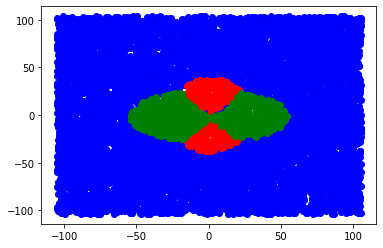

In [4]:
# Given class properties
prior_class1 = 0.5
prior_class2 = 0.4
prior_class3 = 0.2

mean_class1 = np.array([1, 1])
mean_class2 = np.array([1, 0])
mean_class3 = np.array([0, -1])

cov_class1 = np.array([[1, 0],[0, 0.5]])
cov_class2 = np.array([[0.5, 0],[0 ,1]])
cov_class3 = np.array([[2.0, 0],[0, 0.5]])

# Define points for feature space
# How do we define what the bounds of the feature space are?
x1, y1 = np.random.multivariate_normal(mean_class1, cov_class1, 10000).T
x2, y2 = np.random.multivariate_normal(mean_class2, cov_class2, 10000).T
x3, y3 = np.random.multivariate_normal(mean_class3, cov_class3, 10000).T

x_min = np.min([np.min(x1), np.min(x2), np.min(x3)]) - 100
x_max = np.max([np.max(x1), np.max(x2), np.max(x3)]) + 100
y_min = np.min([np.min(y1), np.min(y2), np.min(y3)]) - 100
y_max = np.max([np.max(y1), np.max(y2), np.max(y3)]) + 100

# Sample the feature space
# Can the bounds be arbritrary that I choose or not for what part of the feature space is sampled?
x_vals = np.linspace(x_min, x_max, 10000)
y_vals = np.linspace(y_min, y_max, 10000)

np.random.shuffle(x_vals)
np.random.shuffle(y_vals)

# Determine class labeled for the sampled data
class_1 = []
class_2 = []
class_3 = []

for i in range(len(x_vals)):
    data_point=np.array([x_vals[i], y_vals[i]])
    class_1_apos_prob = get_class_cond_prob(mean_class1, cov_class1, data_point)*prior_class1
    class_2_apos_prob = get_class_cond_prob(mean_class2, cov_class2, data_point)*prior_class2
    class_3_apos_prob = get_class_cond_prob(mean_class3, cov_class3, data_point)*prior_class3
    class_label = np.argmax([class_1_apos_prob, class_2_apos_prob, class_3_apos_prob])
    if class_label == 0:
        class_1.append(data_point)
    elif class_label == 1:
        class_2.append(data_point)
    else:
        class_3.append(data_point)

x_1, y_1 = np.array(class_1).T
x_2, y_2 = np.array(class_2).T
x_3, y_3 = np.array(class_3).T

plt.scatter(x_1, y_1, c='b')
plt.scatter(x_2, y_2, c='r')
plt.scatter(x_3, y_3, c='g')
plt.show()

#### Problem 2

Implement the Pegasos algorithm for finding a linear SVM classifier which separates the training data generated below. Experiment with three different choices for the regularization parameter and plot the resulting separating plane. Explain how the choice of C effects the resulting solution. Hint: the algorithm might show better convergence if you use the projection normalization step. Also, you can consult with any literature beyond the course notes, but you must write your own code.

In [178]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [179]:
# Let's make up some random data to use to build our SVM classifier
data = pd.DataFrame(np.zeros((500, 3)), columns=['x1', 'x2', 'y'])

for i in range(len(data.index)):
    x1 = random.randint(20,100)
    if np.random.random() > 0.5:
        data.iloc[i,0] = 1.0 * x1 
        data.iloc[i,1] = 0.25 * x1 + 60.0 * (random.random() - 0.5) + 65.0
        data.iloc[i,2] = 1.0
    else:
        data.iloc[i,0] = 1.0 * x1
        data.iloc[i,1] = 0.24 * x1 + 40.0 * (random.random() - 0.5) + 0.0 
        data.iloc[i,2] = -1.0
    
# Add in a stray point
data.iloc[0,0] = 50.0
data.iloc[0,1] = 0.25 * x1 + 25.0
data.iloc[0,2] = 1.0

# Now let's normalize this data.

data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()

data.head()
data.describe()

,x1,x2,y
count,5.000000e+02,5.000000e+02,500.000000
mean,8.260059e-17,1.421085e-17,0.044000
std,1.000000e+00,1.000000e+00,1.000032
min,-1.795915e+00,-1.658863e+00,-1.000000
25%,-8.126720e-01,-9.069381e-01,-1.000000
50%,8.507193e-02,1.344090e-02,1.000000
75%,8.973165e-01,9.009806e-01,1.000000
max,1.624062e+00,1.902055e+00,1.000000


In [180]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)

In [181]:
# Sloppy function for plotting our data
def plot_data(X, y):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y > 0
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='-1')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Training Data')
    plt.show()

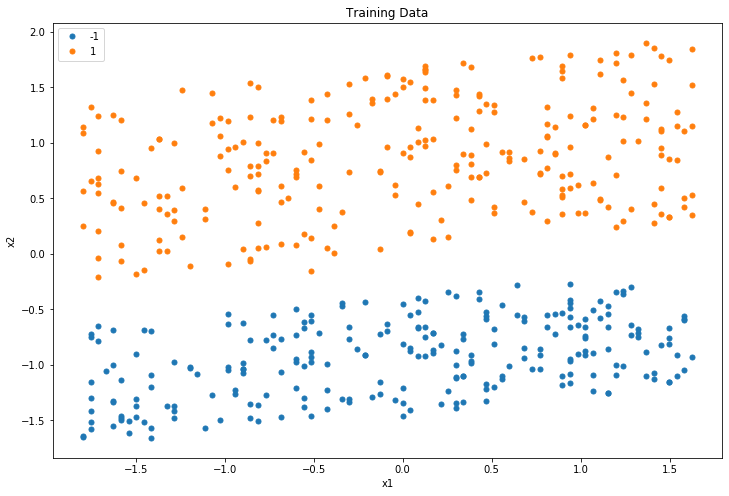

In [182]:
plot_data(X,y)

In [229]:
# Original weight vector
w = np.array([0, 0])

# Regularization parameter?
# This term incorporates C?
reg_param = 5

T = 100
for t in range(T):
    # Are we allowed to pick the same point again?
    # What does uniformly at random mean?
    i = random.randrange(len(X))
    step=t+1
    learning_rate = (1/(step*reg_param))
    cur_val = np.dot(w, X[i].T)
    fin_val = np.dot(y[i], cur_val)
    if fin_val < 1:
        w = (1-learning_rate*reg_param)*w + learning_rate*(np.dot(y[i], X[i]))
    else:
        w = (1-learning_rate*reg_param)*w 
    norm = np.linalg.norm(w)
    w = min(1, (1/np.sqrt(reg_param))/norm)*w
print(w)

[[-0.00965802  0.17693812]]


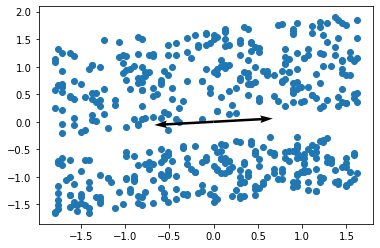

In [230]:
x_1, y_1 = np.array(X).T
w = np.array(w)
plt.scatter(x_1, y_1)
line = []
line.append(-1*w[0][1])
line.append(w[0][0])

plt.quiver(0, 0, line[0], line[1], scale=1)
plt.quiver(0, 0, -1*line[0], -1*line[1], scale=1)
plt.show()